#Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Data Science Portfolio/Rooftop Solar Panel Detection

/content/drive/MyDrive/Data Science Portfolio/Rooftop Solar Panel Detection


In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from keras.layers import Input, Dense, Conv2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.models import model_from_json

#Load Data

In [52]:
# setting directory paths
dir_train_images = "training"
dir_train_labels = "labels_training.csv"

In [53]:
# reading data
df = pd.read_csv("labels_training.csv")

In [54]:
df.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [55]:
# counting label distribution
df['label'].value_counts()

label
0    995
1    505
Name: count, dtype: int64

In [56]:
# load iamge and data from directory returning numpy arrays
def load_data(dir_data,dir_label):
  data=[]
  labels_pd = pd.read_csv('labels_training.csv')
  ids = labels_pd['id'].values
  for id in ids:
    image = cv2.imread(dir_data+'/'+str(id)+'.tif')
    data.append(image)
  data = np.array(data)
  labels = labels_pd['label'].values
  return data,labels

In [57]:
# load image & labels from directories
X, y = load_data(dir_train_images, dir_train_labels)

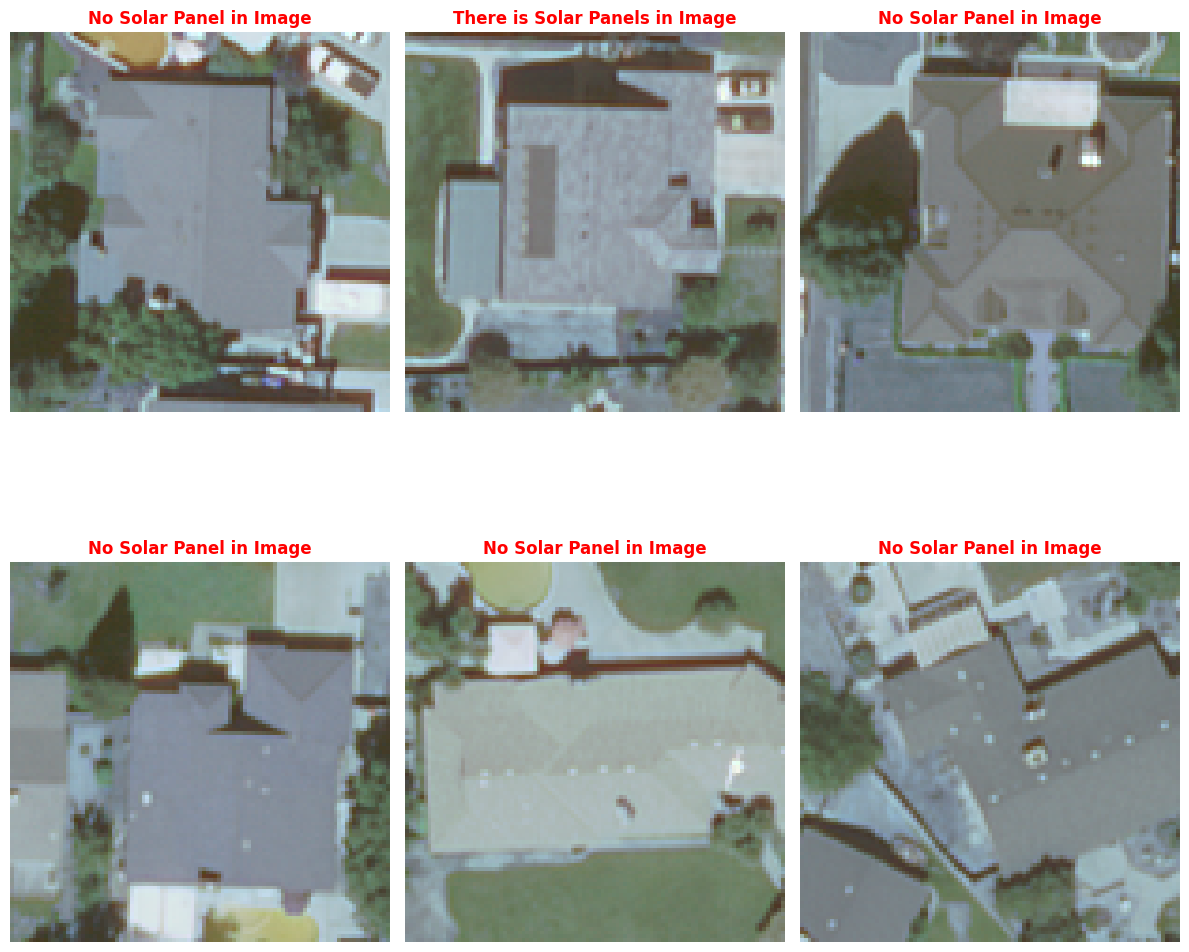

In [58]:
# visualization of random images
plt.figure(figsize=(12,12))

for i in range(6):
  plt.subplot(2,3,i+1)
  k = random.randint(0,len(X))
  if y[k] == 0:
    title = 'No Solar Panel in Image'
  else:
    title = 'There is Solar Panels in Image'
  plt.imshow(X[k])
  plt.title(title, weight = 'bold', color = 'r')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [59]:
print(X.shape,y.shape)

(1500, 101, 101, 3) (1500,)


In [60]:
# normalization of image pixel values
X = X / 255.0

#Build Model

In [61]:
# define the CNN model architecture
def build_model():

    input_layer = Input(shape=(101, 101, 3))

    X = Conv2D(32, (3,3), activation = 'relu')(input_layer)
    X = BatchNormalization()(X)

    X = Conv2D(64, (3,3), activation = 'relu')(X)
    X = BatchNormalization()(X)

    X = Conv2D(128, (3,3), activation = 'relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64, (3,3), activation = 'relu')(X)
    X = BatchNormalization()(X)

    X = Conv2D(128, (3,3), activation = 'relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64, (3,3), activation = 'relu')(X)
    X = BatchNormalization()(X)

    X = Conv2D(128, (3,3), activation = 'relu')(X)
    X = BatchNormalization()(X)

    X = GlobalMaxPooling2D()(X)
    X = Dense(1, activation = 'sigmoid')(X)

    model = Model(inputs = input_layer, outputs = X)

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [62]:
# cross-validation with cnn model training
num_folds = 3
prediction_scores = np.empty(y.shape[0], dtype='object')
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
model = build_model()

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train = y[train_index]

    class_weight = {0: 505/1500, 1: 995/1500}

    training = model.fit(X_train, y_train, class_weight=class_weight, batch_size=32, epochs=50, shuffle=True, verbose=1)

    y_val_pred_probs = model.predict(X_val).reshape((-1, ))
    prediction_scores[val_index] = y_val_pred_probs


Epoch 1/50
32/32 [==============================] - 7s 79ms/step - loss: 0.2993 - accuracy: 0.7220
Epoch 2/50
32/32 [==============================] - 2s 77ms/step - loss: 0.1619 - accuracy: 0.8340
Epoch 3/50
32/32 [==============================] - 2s 78ms/step - loss: 0.1001 - accuracy: 0.9150
Epoch 4/50
32/32 [==============================] - 3s 78ms/step - loss: 0.0715 - accuracy: 0.9470
Epoch 5/50
32/32 [==============================] - 3s 80ms/step - loss: 0.1145 - accuracy: 0.8900
Epoch 6/50
32/32 [==============================] - 2s 78ms/step - loss: 0.0797 - accuracy: 0.9290
Epoch 7/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0392 - accuracy: 0.9710
Epoch 8/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0189 - accuracy: 0.9910
Epoch 9/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0112 - accuracy: 0.9970
Epoch 10/50
32/32 [==============================] - 3s 81ms/step - loss: 0.0134 - accuracy: 0.9920
Epoch 11/

In [63]:
# saving trained model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")

In [4]:
# loading model and weights
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
model.load_weights('model_weights.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Model Evaluation

In [65]:
# adding predicted classes to dataframe
df['predicted_class'] = np.where(prediction_scores >= 0.5, 1, 0)

In [66]:
# calculating confusion matrix
cm = confusion_matrix(np.asarray(df['predicted_class']) ,y)
cm

array([[952,  40],
       [ 43, 465]])

In [67]:
# extracting FN, FP, TP, TN from the dataframe
tp = np.array(df[(df['label']== 1) & (df['predicted_class'] == 1)]['id'])
tn = np.array(df[(df['label']== 0) & (df['predicted_class'] == 0)]['id'])
fp = np.array(df[(df['label']== 0) & (df['predicted_class'] == 1)]['id'])
fn = np.array(df[(df['label']== 1) & (df['predicted_class'] == 0)]['id'])

In [76]:
# showing images with titles
def show_images (image_ids,title,color):
  plt.figure(figsize=(15,10))
  for i in range(1,4):
    plt.subplot(3,4,i+1)
    plt.imshow(X[image_ids[i]])
    plt.title("Image ID:"+str(image_ids[i]))
    plt.axis('off')
  plt.suptitle(title, fontsize = 15, weight = 'bold', color = color)
  plt.tight_layout()
  plt.show()

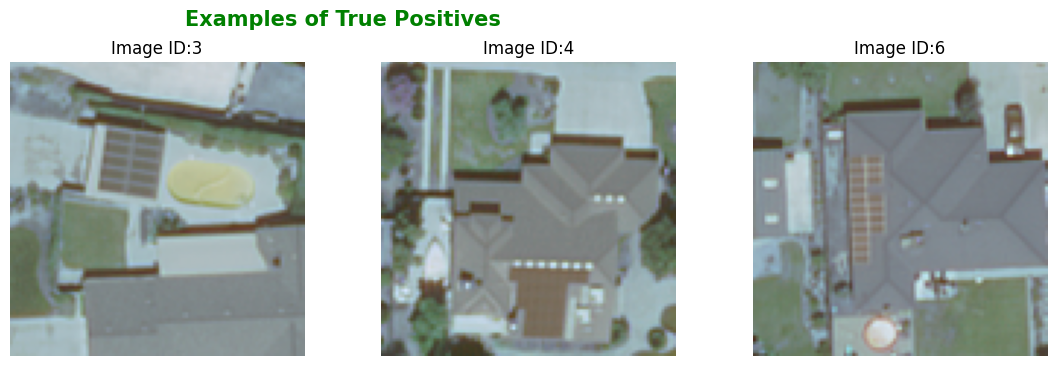

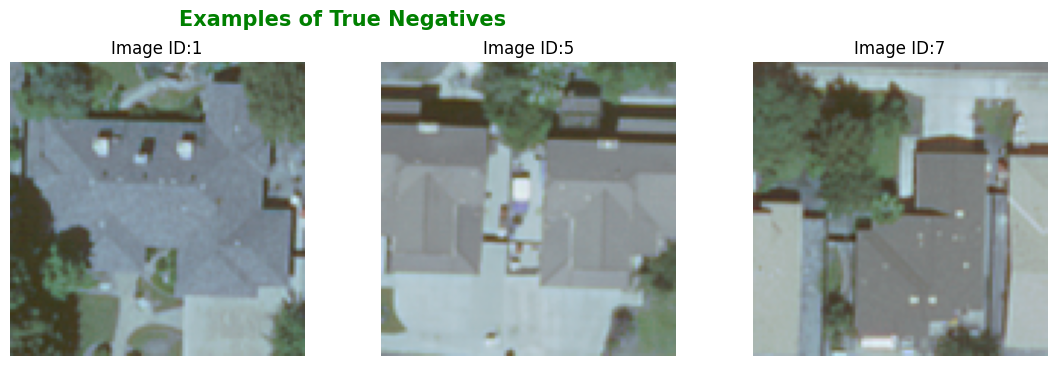

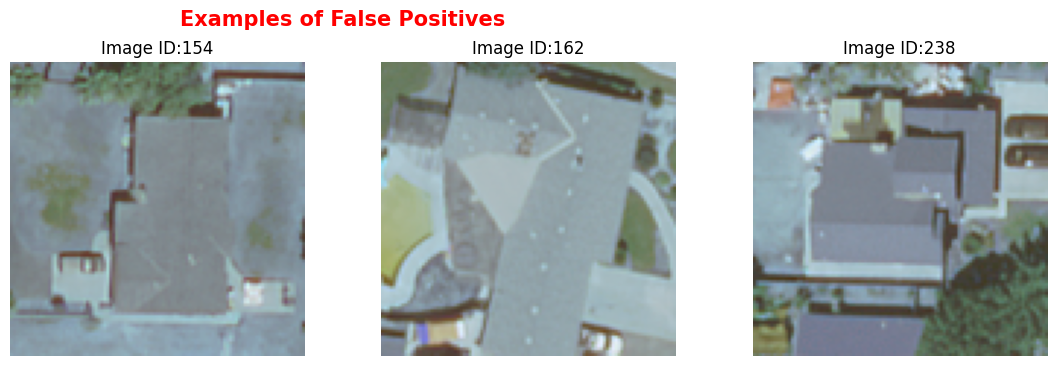

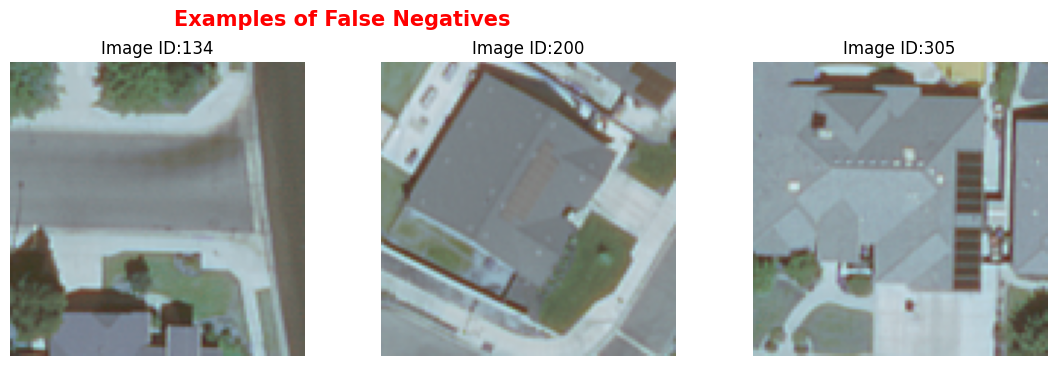

In [77]:
# displaying examples of FN, FP, TP, TN
show_images(tp, 'Examples of True Positives', 'g')
show_images(tn, 'Examples of True Negatives', 'g')
show_images(fp, 'Examples of False Positives', 'r')
show_images(fn, 'Examples of False Negatives', 'r')

In [78]:
# compute roc auc score
roc_auc = roc_auc_score(y, prediction_scores)
roc_auc

0.982949400467685

In [79]:
# compute roc curve
fpr, tpr, thresholds = roc_curve(y, prediction_scores)

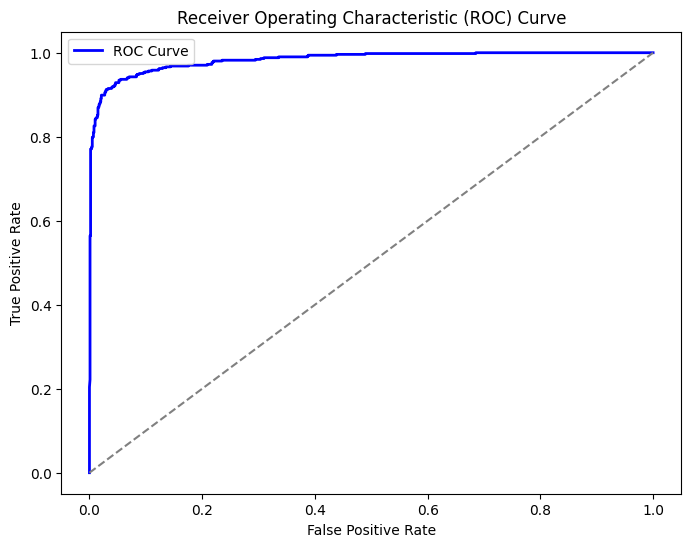

In [80]:
# plot roc curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [72]:
# Load the test images from the testing folder
def load_test_data(dir_data):
    test_data = []
    test_ids = []

    # Iterate through the files in the testing folder
    for file_name in os.listdir(dir_data):
        # Read the image file
        image = cv2.imread(os.path.join(dir_data, file_name))
        # Append the image data to the list
        test_data.append(image)
        # Extract the ID from the file name and append it to the list
        test_ids.append(file_name[:-4])  # Remove the file extension (.tif)

    # Convert the lists to numpy arrays
    test_data = np.array(test_data)

    return test_data, test_ids

# Define the directory path for the testing data
dir_test_images = "testing"

# Load the test data
X_test, test_ids = load_test_data(dir_test_images)

# Normalize the pixel values of the test images
X_test = X_test / 255.0

# Make predictions on the test data
y_test_pred_probs = model.predict(X_test).reshape((-1, ))

# Post-processing (if necessary)
# For example, thresholding the probabilities to get binary predictions:
y_test_pred = np.where(y_test_pred_probs >= 0.5, 1, 0)

# Display the predictions
for image_id, prediction in zip(test_ids, y_test_pred):
    print(f"Image ID: {image_id}, Predicted Class: {'Solar Panel' if prediction == 1 else 'No Solar Panel'}")


#Predicting Solar Panels in Test Images

In [7]:
# function to load the test images from the testing folder
def load_test_data(dir_data):
    test_data = []
    test_ids = []

    # iterate through the files in the testing folder
    for file_name in os.listdir(dir_data):
        image = cv2.imread(os.path.join(dir_data, file_name))
        # append the image data to the list
        test_data.append(image)
        # extract the ID from the file name and append it to the list
        test_ids.append(file_name[:-4])  # Remove the file extension (.tif)

    # convert the lists to numpy arrays
    test_data = np.array(test_data)

    return test_data, test_ids

# define the directory path for the testing data
dir_test_images = "/content/drive/MyDrive/Data Science Portfolio/Rooftop Solar Panel Detection/testing"

# load the test data
X_test, test_ids = load_test_data(dir_test_images)

# normalize pixel values of the test images
X_test = X_test / 255.0

# make predictions on test data
y_test_pred_probs = model.predict(X_test).reshape((-1, ))

y_test_pred = np.where(y_test_pred_probs >= 0.5, 1, 0)

# print predictions
for image_id, prediction in zip(test_ids, y_test_pred):
    print(f"Image ID: {image_id}, Predicted Class: {'Solar Panel' if prediction == 1 else 'No Solar Panel'}")


18/18 [==============================] - 2s 117ms/step
Image ID: 1793, Predicted Class: No Solar Panel
Image ID: 2035, Predicted Class: No Solar Panel
Image ID: 1727, Predicted Class: Solar Panel
Image ID: 1680, Predicted Class: No Solar Panel
Image ID: 1611, Predicted Class: No Solar Panel
Image ID: 2030, Predicted Class: Solar Panel
Image ID: 1936, Predicted Class: No Solar Panel
Image ID: 1813, Predicted Class: No Solar Panel
Image ID: 1949, Predicted Class: No Solar Panel
Image ID: 2017, Predicted Class: No Solar Panel
Image ID: 1925, Predicted Class: No Solar Panel
Image ID: 1550, Predicted Class: Solar Panel
Image ID: 2024, Predicted Class: Solar Panel
Image ID: 2015, Predicted Class: No Solar Panel
Image ID: 1720, Predicted Class: No Solar Panel
Image ID: 2008, Predicted Class: Solar Panel
Image ID: 1819, Predicted Class: No Solar Panel
Image ID: 1917, Predicted Class: No Solar Panel
Image ID: 1701, Predicted Class: Solar Panel
Image ID: 1625, Predicted Class: No Solar Panel
Ima